# Quora Insincere Questions Part 1: Exploratory Data Analysis.

Digging into the [Quora Insincere Questions Classification](https://www.kaggle.com/c/quora-insincere-questions-classification) training data.

From the competition description. Highlights mine:

An insincere question is defined as a **question intended to make a statement** rather than look for helpful answers. Some characteristics that can signify that a question is insincere:

Has a non-neutral tone
Has an exaggerated tone to underscore a point about a group of people
Is rhetorical and meant to imply a statement about a group of people
Is disparaging or inflammatory
Suggests a discriminatory idea against a protected class of people, or seeks confirmation of a stereotype
Makes disparaging attacks/insults against a specific person or group of people
Based on an outlandish premise about a group of people
Disparages against a characteristic that is not fixable and not measurable
Isn't grounded in reality
Based on false information, or contains absurd assumptions
Uses sexual content (incest, bestiality, pedophilia) for shock value, and not to seek genuine answers
The training data includes the question that was asked, and whether it was identified as insincere (target = 1). The ground-truth labels contain some amount of noise: they are not guaranteed to be perfect.

Note that the distribution of questions in the dataset should not be taken to be representative of the distribution of questions asked on Quora. This is, in part, because of the combination of sampling procedures and sanitization measures that have been applied to the final dataset.

In [351]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import os

## Import Training Data

In [311]:
# Select local path vs kaggle kernel
path = os.getcwd()
if 'data-projects/kaggle_quora/notebooks' in path:
    data_dir = '../data/raw/'
else:
    data_dir = ''

In [312]:
dat = pd.read_csv(data_dir +'train.csv')

In [313]:
dat.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg hemispheres?,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain bike by just changing the tyres?,0


In [314]:
dat.shape

(1306122, 3)

## Getting a feel for insincere vs sincere questions

First lets take a look at the full text for a sample of "sincere" questions. They are shorter than I expected. Spelling is fairly good, grammer is a little spottier. Not an overabundance of typos.

In [315]:
# Sincere questions
for q in dat['question_text'][dat['target'] == 0].sample(10):
    print(q)

Why do some Quora users think that short answers are not worthy?
What are the implementaion needs to department of aids control?
Does every contract need to have an offer and acceptance?
Which one has the scope in future an embedded engineer or VLSI engineer?
As an Islamic scholar, how would you defend Islam and the Quran from the ill reputation it has garnered from terrorists who base their actions in Islam?
What is a twin blaster cannon in Star Wars? What kind of damage can it do?
I have around 65% in my engineering. Should I prepare for CAT 2018?
What is the easiest way to buy Cardano?
Can I watch free pornography?
How would a Medieval era society interact with an early Hominid species?


Initial impressions: 
Religious / cultural items:
"Why are Muslim beliefs tolerated and accepted, while Nazis beliefs are not, even when they are the same (e.g. belief in superiority over others, hate of homosexuals, disrespect for women)?"
"If a Hindu woman is not better than a Muslim woman according to Islam, why do Muslims approach Hindu women for love and marriage?"
"What will you do if you spot a Muslim having sex with a female dog?"

US Political and "liberal media" items:
"Is it possible for liberal agents in the FBI to abuse their authority while investigating Trump?"
"How do the news brainwash people into liberalism (appropriate answers only)?"
"Why is the Democrats' media suddenly miraculously concerned with the President's ethics and scandals? Not a peep during Obama's eight years."
"Is it ok for liberals to insult Trump supporters, but not ok for Trump supporters to insult liberals?"
"Why do liberals, when they don't have any arguments in political discussion, call the opponent ''racist'', ''sexist'', or ''xenophobic''?"
"Can Trump supporters read?"
"When will dictator Donald Trump be tried at the Hague?"
"Did liberals really believe that Trump's sons illegally shot and killed a Triceratops?"

Indian Political items:
"Does Prakash Raj think that the people of 20 states of India are fools to vote for Modi in assembly elections?"

Sexually "shocking" items:
"What does sex with a cousin feels like?"
"Does anyone of your aunt tries to have sexual relationship with you?"

Transphobic / homophobic items:
"Why do homosexual people exist in nature, it doesn’t make sense biologically speaking?"
"Does shaving buttocks make you gay?"

Misogynistic / anti-feminist items:
"Do women have emotions and feelings?"
"Why do feminists think they're for equal rights? When egalitarianism is the real way to achieve this?"
"Why do some bitches expect virgin guys as partners?"

Racist items:
"Why are blacks so uncivilized?"
"If we removed all blacks from Obamacare, would it be more affordable to real Americans?"

Nazi / holocaust items:
What happens when someone had diarrhea in the holocaust?
What is the politically correct spelling: Ass-con-Nazi or Ask-Ken-Nazi?

In [316]:
# Insincere questions
for q in dat['question_text'][dat['target'] == 1].sample(10):
    print(q)

Is Indian organized crime formed mostly by Muslims and Dalits?
What is the legality of incest in Japan?
I had a conservative friend ask me how people can be pro-choice and be upset at children being separated from their families at the border, simultaneously. Are conservatives really serious about this?
Why are mental health workers fake as fuck?
Why do so many Americans, especially high profile one, choose to be willfully ignorant?
Could Muslims breed so much that they completely overwhelm non-Muslims and kill us all with an overwhelming weight of numbers, and how can we stop them?
Why do Chinese Malaysians believe that Malays will live on trees and in the jungle without Chinese Malaysians developing the country?
How can we increase diversity in Israel so Jews will become a minority in a multicultural rainbow nation?
[math]24-7=?[/math]
Was this site always this mindless or has said situation evolved over time as more people use it?


Casual observations:
* Text appears longer
* More misspellings and gramatical issues, but not as much as I would have expected
* More strong language, eg. "stupid", "idiot", "hate", "irrational", "disgusting"...
* More likely to start with "Why" rather than "How", "What" or "Where".
* What do some "sincere" questions about Trump, liberals, Muslims and sex look like? I suspect those are going to be extremely tough to disambiguate.

In [317]:
pd.set_option('display.max_colwidth', -1)

trump_questions = dat['question_text'].apply(lambda x: "Trump" in x)

sincere_trump = dat[np.logical_and(trump_questions, dat['target'] == 0)]
insincere_trump = dat[np.logical_and(trump_questions, dat['target'] == 1)].sample(10).reset_index()

side_by_side_trump = pd.DataFrame({'sincere': sincere_trump['question_text'].sample(10).values,
                                                           'insincere': insincere_trump['question_text'].sample(10).values})

side_by_side_trump

,sincere,insincere
0,"I love Trump for his money, is it normal?",Are liberals aware that Trump won the popular vote in 30 out of 50 states?
1,How do Donald Trump's first 100 days compare to Obama's first 100?,Why is Trey Gowdy being disloyal to President Trump in Memogate?
2,"Does Donald Trump have any good qualities? Are there any standards or lines he won't cross, or does he have any humanizing moments that are sincere?",How severely has Trump damaged the US thus far? How long will it take to recover once he's gone and we can get some less damaging people in the White House and Congress?
3,Is media giving a good news about Trump or bad news about him?,What percentage of the Trump supporters hate Obama merely on the fact that he is black?
4,How are people waking up from long term coma's reacting to Trump's presidency?,"If Donald Trump is so extremely irresponsible, how does he not end up in trouble?"
5,"Considering how Trump's been doing so far as a president, is it really realistic he'll sit for the entire 4 years?",There are already way too many minorities in the USA. Isn't it about time Trump stopped all refugees and asylum seekers from coming into the USA? The protection was supposed to be 'temporary' anyways?
6,"By doing the crazy man strategy and everyone else wanting to prove him wrong, is Trump bringing world peace in a bizarre end justifies the mean way?","Why, after Trump cheated to get to be president, should Hillary take his place?"
7,"Who were the sources for reporting Trump's ""shithole"" comment to the press?",Isn't it time once and for all that Robert Mueller admit there is no connection with Donald Trump and collusion after wasting so much time and taxpayer money?
8,Is the Trump presidency sustainable?,Why does everyone on Quora hate President Trump?
9,Is Trump the most dishonest president we have ever had?,"When will conservative lawmakers and their cohorts finally realize that Trump is a dumpster fire president, as well as a lying, vindictive, shallow con artist with seemingly no sense of decency or mental fortitude?"


These were classed as "sincere":

"If everyone agrees that Trump is a total failure as president, why is he still president?"
"Will Trump stage a terrorist attack to gain support for himself and save his administration?"
"Why are Conservatives so lazy that they have put faith in Trump uplifting their lives?"

And this is "insincere":
"Why would President Trump push to move the embassy to Jerusalem? What possible benefit is there to the United States?"

So we can see this is an unevenly applied classification, presumably by human moderators who are doing their darndest. This will be difficult to classify, and I would say that Quora should probably have an iterative model-review-reclassify-remodel process to improve the quality of their tagging, particularly for high-value topics.

### Can we identify some frequently insincere topics by inspection or other research?

#### US Political

In [318]:
topics = ['trump', 'hillary', 'liberal', 'russia', 'spies', 'pizzagate', 'liberal media']

insincere_count = 0
questions_count = 0

def calculate_word_target_proportions(df, words, verbose=True):
    print('{}% insincere - overall ({} / {})'.format(100*df.target.mean().round(3),
                                                    df.target.sum(),
                                                    len(df.target)))
    props = []
    insincere_count = 0
    questions_count = 0
    for word in words:
        filter = df['question_text'].apply(lambda x: word in x.lower())
        if filter.sum() > 0:
            props.append([(100*df[filter].target.mean()).round(1), 
                                                            word,
                                                           df[filter].target.sum(),
                                                           len(df[filter].target)])
            insincere_count += df[filter].target.sum()
            questions_count += len(df[filter].target)

    if verbose:
        for prop in sorted(props, reverse=True):
            print('{0}% insincere - {1} ({2} / {3})'.format(*prop))
        
    return props, insincere_count, questions_count
        
p, i, q = calculate_word_target_proportions(dat, topics)
insincere_count = insincere_count + i
questions_count = questions_count + q

6.2% insincere - overall (80810 / 1306122)
70.5% insincere - liberal media (43 / 61)
63.7% insincere - liberal (2756 / 4324)
63.5% insincere - hillary (785 / 1236)
61.1% insincere - pizzagate (11 / 18)
43.5% insincere - trump (6145 / 14128)
23.8% insincere - russia (1374 / 5778)
21.4% insincere - spies (27 / 126)


#### Race, Religion and Cultural Identities

In [319]:
race_rel_culture = ['black', 'black lives','muslim']
p, i, q = calculate_word_target_proportions(dat, race_rel_culture)
insincere_count = insincere_count + i
questions_count = questions_count + q

6.2% insincere - overall (80810 / 1306122)
69.5% insincere - black lives (73 / 105)
59.0% insincere - muslim (4725 / 8009)
37.7% insincere - black (3155 / 8376)


#### Gender & Sexual Orientation

In [320]:
gender_sex = ['woman', ' man', 'women', 'trans ', ' men', 'dyke', 'fag', 'queer', 'femin', 'transgender']

p, i, q = calculate_word_target_proportions(dat, gender_sex)
insincere_count = insincere_count + i
questions_count = questions_count + q

6.2% insincere - overall (80810 / 1306122)
51.0% insincere - femin (981 / 1922)
43.2% insincere - women (5323 / 12323)
42.9% insincere - dyke (3 / 7)
42.2% insincere - transgender (341 / 808)
35.4% insincere - trans  (90 / 254)
30.8% insincere - fag (8 / 26)
29.6% insincere -  men (4352 / 14706)
22.8% insincere - woman (1194 / 5246)
21.6% insincere - queer (16 / 74)
11.0% insincere -  man (5317 / 48404)


#### Sex & Anatomy

In [321]:
sex_anatomy = ['sex', 'boob', 'butt', ' ass', 'asshole', 'bollok', 'blow job', 'blowjob', 'bugger'
              'boner', 'buttplug', 'dildo', 'clitoris', 'cock', 'cunt', 'twat', 'pube', 'vagina', 
               'wank', 'whore', 'hooker']

p, i, q = calculate_word_target_proportions(dat, sex_anatomy)
insincere_count = insincere_count + i
questions_count = questions_count + q

6.2% insincere - overall (80810 / 1306122)
77.1% insincere - cunt (54 / 70)
69.7% insincere - asshole (168 / 241)
61.3% insincere - whore (65 / 106)
46.5% insincere - blowjob (53 / 114)
45.9% insincere - wank (17 / 37)
41.8% insincere - hooker (23 / 55)
37.1% insincere - boob (109 / 294)
33.3% insincere - buttplug (1 / 3)
33.3% insincere - blow job (16 / 48)
30.6% insincere - vagina (190 / 621)
30.0% insincere - dildo (18 / 60)
29.7% insincere - sex (4350 / 14664)
27.3% insincere - clitoris (9 / 33)
24.2% insincere - cock (149 / 616)
13.6% insincere -  ass (1249 / 9165)
13.0% insincere - butt (264 / 2026)
10.5% insincere - pube (27 / 257)
5.8% insincere - twat (7 / 120)


#### Words associated with bullying / trolling / insults

Taisei Nitta, Fumito Masui, Michal Ptaszynski, Yasutomo Kimura, Rafal Rzepka, and Kenji Araki. 2013. Detecting
cyberbullying entries on informal school websites based on category relevance maximization. In IJCNLP,
pages 579–586.

Raisi, et al (2016)

In [322]:
trolling = ['disgust', 'hate', 'idiot', 'stupid', 'irrational', 'annoying', 
            'gross', 'slut', 'fellatio', 'die', 'kill', 'faggot', 'fag', 'pathetic', 'pussy',
           'nigger', 'ignorant', 'lying', 'communist', 'trash', 'dumb', 'worthless',
           'nazi', 'jerk', 'asshole', 'dick', 'prick']

p, i, q = calculate_word_target_proportions(dat, trolling)
insincere_count = insincere_count + i
questions_count = questions_count + q

6.2% insincere - overall (80810 / 1306122)
69.7% insincere - asshole (168 / 241)
65.9% insincere - pussy (149 / 226)
65.2% insincere - ignorant (313 / 480)
64.9% insincere - idiot (347 / 535)
64.3% insincere - nigger (27 / 42)
54.5% insincere - dick (331 / 607)
53.7% insincere - slut (95 / 177)
51.0% insincere - stupid (1066 / 2091)
46.2% insincere - fellatio (6 / 13)
42.9% insincere - faggot (6 / 14)
37.9% insincere - dumb (451 / 1189)
37.8% insincere - hate (2670 / 7067)
37.6% insincere - disgust (163 / 434)
37.1% insincere - nazi (530 / 1427)
36.1% insincere - jerk (99 / 274)
34.5% insincere - trash (118 / 342)
31.8% insincere - prick (14 / 44)
31.8% insincere - pathetic (112 / 352)
30.8% insincere - fag (8 / 26)
30.4% insincere - communist (261 / 858)
20.2% insincere - irrational (57 / 282)
18.8% insincere - kill (2070 / 11009)
18.7% insincere - worthless (32 / 171)
18.4% insincere - annoying (115 / 624)
9.9% insincere - lying (326 / 3302)
9.2% insincere - gross (29 / 315)
7.4% ins

#### Curses!

In [323]:
curse = ['asshole', 'fuck', 'cunt', 'ass', 'bastard', 'bitch', 'bugger', 'crap', 'damn', 'f u c k', 'feck'
        'hell ', 'piss', 'poop', 'turd']

p, i, q = calculate_word_target_proportions(dat, curse)
insincere_count = insincere_count + i
questions_count = questions_count + q

6.2% insincere - overall (80810 / 1306122)
77.1% insincere - cunt (54 / 70)
69.9% insincere - fuck (709 / 1014)
69.7% insincere - asshole (168 / 241)
59.1% insincere - bitch (146 / 247)
54.8% insincere - bastard (51 / 93)
50.0% insincere - damn (79 / 158)
35.0% insincere - piss (78 / 223)
29.7% insincere - poop (107 / 360)
21.8% insincere - crap (119 / 547)
10.9% insincere - turd (25 / 230)
8.2% insincere - ass (3248 / 39664)
0.0% insincere - bugger (0 / 6)


Context is pretty important here. Danescu-Niculescu-Mizil's corpus is based on Stack Exchange comments, which are inherently non-poltical. I can see how "You're welcome" and "Thanks a lot" could be associated with false-sincerity or straight sarcasm on Quora.

So I guess, in Quora's case, "Welcome" isn't very welcoming! :P

#### Conclusion

In [324]:
print('Targets: {} / Overall Targets: {}. {}%'.format(insincere_count, dat['target'].sum(),
                                                      (100*insincere_count/dat['target'].sum()).round(1)))
print('Questions: {} / Overall Questions: {}. {}%'.format(questions_count, len(dat['target']),
                                                          round(100*questions_count/len(dat['target']),1)))

Targets: 58935 / Overall Targets: 80810. 72.9%
Questions: 244356 / Overall Questions: 1306122. 18.7%


There's double counting in here, I'd have to check how much, but these terms account for approximately 19% of questions but 78% of insincere questions.

Answer: yes, very much so. References to Liberals and Hillary, the Holocaust and Muslims are flagged as insincere in well over 50% of occurances. References to Trump are insincere over 40% of the time, which is a lot given the base rate is only 6%. So these words along will be strong signals. But there are sincere questions about, say, Trump. An easy model would simply flag all questions about Liberals and Hillary as insincere, and possibly do quite well overall.

What will be interesting is the nuance between sincere and popular questions on topics that are frequenly insincere. Consider modelling frequent topics with high target rates separately and ensembling.

TODO: Cluster analysis / topic modelling for targets to see if any other themes can be identified.

### Words associated with politeness

Hey, there's some research on identifying *politeness*! This is the opposite, perhaps useful as a feature for non-targets?
http://www.cs.cornell.edu/~cristian/Politeness.html

In [325]:
politeness = ['thanks', 'thank you', 'appreciate', 'awesome', 'please', 'share', 'welcome']
p, i, q = calculate_word_target_proportions(dat, politeness)

6.2% insincere - overall (80810 / 1306122)
21.9% insincere - welcome (71 / 324)
13.6% insincere - thanks (59 / 435)
12.0% insincere - please (255 / 2124)
11.4% insincere - appreciate (61 / 537)
7.5% insincere - thank you (21 / 279)
6.7% insincere - awesome (22 / 327)
4.1% insincere - share (174 / 4277)


### What about Internet Abbreviations?

In [326]:
internet = ['lol', 'rolf', 'yolo', 'lmfao', 'stfu', 'omg', 'lmk', 'smh', 'nvm', 'ikr']
p, i, q = calculate_word_target_proportions(dat, internet)

6.2% insincere - overall (80810 / 1306122)
100.0% insincere - smh (1 / 1)
17.6% insincere - stfu (12 / 68)
17.5% insincere - lol (41 / 234)
15.6% insincere - omg (5 / 32)
9.1% insincere - rolf (1 / 11)
4.0% insincere - yolo (1 / 25)
1.4% insincere - ikr (1 / 71)
0.0% insincere - nvm (0 / 6)
0.0% insincere - lmk (0 / 1)
0.0% insincere - lmfao (0 / 1)


Not very common and not very strong signals. Ok then!

## Question Structure: Leading Why vs How / Which / What?

In [327]:
dat['leading_word'] = dat['question_text'].apply(lambda x: x.split()[0].lower())

In [328]:
summary = dat.groupby('leading_word')['target'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)
summary['percent_of_qs'] = summary['count'].apply(lambda x: round(100*x/dat.shape[0],1))
summary = summary.rename(columns={'mean': 'percent_targets'})
summary.loc[summary['percent_of_qs'] > 1,['percent_targets', 'percent_of_qs', 'count']]

,percent_targets,percent_of_qs,count
leading_word,,,
why,0.225128,10.3,134621
are,0.146523,2.0,25839
do,0.133801,2.7,35523
if,0.104519,2.1,27641
is,0.068536,7.3,95191
does,0.061599,1.5,20179
i,0.059630,1.6,20560
who,0.034198,1.6,21054
can,0.029351,3.7,48482


Leading Whys are overwhelmingly far more likely to be insincere! 
I wonder linguistically what is going on there...

Is it that "why" and (to a lesser extent) "are" lead questions confirmatory phrasing? In that you're trying to get someone to agree with an initial premise. "Why are Xs into Z?" or "Are all Xs into Z"?

## Topic Modeling

Quick topic modeling, to see whether anything interesting pops out.
Quick and dirty as a first pass, reference [AWS](https://rstudio-pubs-static.s3.amazonaws.com/79360_850b2a69980c4488b1db95987a24867a.html) and [DataCamp](https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python). 
(Interestingly there's some verbatim code copying across these two articles. Someone stole someone
elses' code and didn't cite them! tut!)

TODO: add evaluation of coherence and test different numbers of topics.

In [372]:
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim

In [366]:
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = get_stop_words('en')
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    
    # list for tokenized documents
    texts = []

    # loop through document list
    for question in doc_set:

        # clean and tokenize document string
        raw = question.lower()
        tokens = tokenizer.tokenize(raw)

        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]

        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]

        # add tokens to list
        texts.append(stemmed_tokens)
        
    return texts

def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # turn our tokenized documents into a id <-> term dictionary
    dictionary = corpora.Dictionary(doc_clean)

    # convert tokenized documents into a document-term matrix
    corpus = [dictionary.doc2bow(text) for text in doc_clean]
    
    return dictionary, corpus

In [367]:
%timeit

# preprocess questions
doc_clean = preprocess_data(list(dat.question_text.values))

# Create corpus and dictionary
dictionary, corpus = prepare_corpus(doc_clean)

In [368]:
print(dictionary)

Dictionary(153239 unique tokens: ['1960', 'nation', 'nationalist', 'provinc', 'quebec']...)


In [369]:
# %timeit

# # generate LDA model
# ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word = dictionary, passes=20)
# ldamodel.save('lda.model')

In [398]:
print(ldamodel.print_topics(num_topics=10, num_words=10))

[(0, '0.034*"s" + 0.013*"war" + 0.013*"class" + 0.012*"book" + 0.012*"read" + 0.010*"major" + 0.010*"black" + 0.010*"man" + 0.009*"c" + 0.008*"forc"'), (1, '0.016*"state" + 0.015*"student" + 0.013*"will" + 0.013*"s" + 0.013*"indian" + 0.012*"import" + 0.011*"system" + 0.010*"scienc" + 0.010*"govern" + 0.010*"manag"'), (2, '0.038*"use" + 0.035*"best" + 0.033*"can" + 0.020*"way" + 0.018*"learn" + 0.018*"work" + 0.015*"compani" + 0.013*"start" + 0.011*"develop" + 0.011*"busi"'), (3, '0.022*"engin" + 0.019*"trump" + 0.014*"mean" + 0.011*"prepar" + 0.011*"studi" + 0.011*"univers" + 0.011*"best" + 0.011*"cours" + 0.010*"social" + 0.009*"complet"'), (4, '0.040*"can" + 0.015*"1" + 0.015*"use" + 0.013*"buy" + 0.012*"best" + 0.011*"number" + 0.011*"account" + 0.010*"servic" + 0.009*"get" + 0.009*"test"'), (5, '0.026*"countri" + 0.018*"live" + 0.017*"american" + 0.015*"peopl" + 0.014*"india" + 0.012*"like" + 0.011*"world" + 0.010*"differ" + 0.010*"us" + 0.010*"consid"'), (6, '0.031*"can" + 0.016*

In [399]:
corpus_topics = ldamodel.get_document_topics(corpus, per_word_topics=False)
doc_topics = [doc_topics for doc_topics in corpus_topics]

In [400]:
q_i = 8
print(corpus_topics[q_i])
print(max(corpus_topics[q_i], key=lambda x: x[1]))
print(dat.question_text[q_i])

[(0, 0.35107583), (1, 0.5346326), (2, 0.014286676), (3, 0.014286632), (4, 0.014286356), (5, 0.014287392), (6, 0.014286448), (7, 0.014285714), (8, 0.014286613), (9, 0.014285714)]
(1, 0.5346332)
Is there such a thing as dressing moderately, and if so, how is that different than dressing modestly?


## Is sentiment associated with insincerity?

Strictly speaking applying a sentiment analysis involves another corpus, so it isn't valid for this competition. But I'm curious whether my intuition is correct on this one!

In [337]:
from textblob import TextBlob

In [347]:
dat['sentiment'] = dat.question_text.apply(lambda x: TextBlob(x).sentiment)
dat['polarity'] = dat['sentiment'].apply(lambda x: x.polarity)
dat['subjectivity'] = dat['sentiment'].apply(lambda x: x.subjectivity)

In [349]:
dat.head()

,qid,question_text,target,leading_word,sentiment,polarity,subjectivity
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0,how,"(0.0, 0.0)",0.0,0.0
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0,do,"(0.0, 0.0)",0.0,0.0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0,why,"(0.0, 0.0)",0.0,0.0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg hemispheres?,0,how,"(0.0, 0.0)",0.0,0.0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain bike by just changing the tyres?,0,can,"(0.0, 0.0)",0.0,0.0


In [353]:
dat[['polarity', 'subjectivity', 'target']].groupby('target').mean()

,polarity,subjectivity
target,,
0,0.104876,0.270181
1,0.028165,0.360340


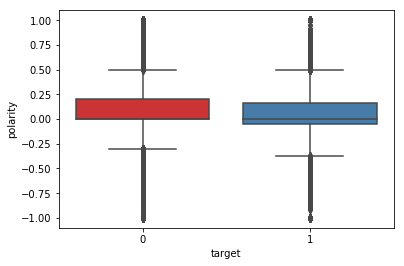

In [352]:
# Grouped boxplot
sns.boxplot(x="target", y="polarity", data=dat, palette="Set1")

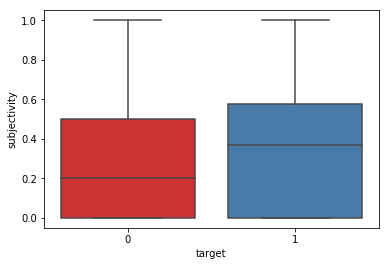

In [354]:
# Grouped boxplot
sns.boxplot(x="target", y="subjectivity", data=dat, palette="Set1")

Polarity is slightly higher for the sincere questions, meaning that they are slightly more positive.
Subjectivity is slightly higher among insincere questions.
These differences aren't large, but they do follow the expected directionality.

TextBlob uses the Pattern library, which in turn uses a corpus based on movie reviews. This may not map very well to the types of language used on Quora.